# 第27章预训练语言模型

## 习题27.1
&emsp;&emsp;设计基于双向LSTM的预训练语言模型，假设下游任务是文本分类。

**解答：**  

**解答步骤：**  

**解答思路：**

1. 设计基于双向LSTM的预训练模型ELMo，并加载模型权重
2. 设计基于ELMo的文本分类模型
3. 自编程实现基于ELMo的文本分类

**第1步：设计基于双向LSTM的预训练模型ELMo，并加载模型权重**

&emsp;&emsp;ELMo是一个双向LSTM模型，它首先使用大规模文本语料库进行预训练，当用于下游任务时，其输出表示通常作为上下文相关的词向量。（论文参考链接：https://arxiv.org/abs/1802.05365 ）

&emsp;&emsp;ELMo有多个不同模型大小的变体，这里我们以small版本为例，详见：https://allenai.org/allennlp/software/elmo.

In [1]:
import wget
import os
from allennlp.modules.elmo import Elmo

In [2]:
elmo_options_file = './data/elmo_2x1024_128_2048cnn_1xhighway_options.json'
elmo_weight_file = './data/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5'
url = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_options.json"
if(not os.path.exists(elmo_options_file)):
    wget.download(url, elmo_options_file)
url = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x1024_128_2048cnn_1xhighway/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5"
if(not os.path.exists(elmo_weight_file)):
    wget.download(url, elmo_weight_file)

In [3]:
# 加载模型
elmo = Elmo(elmo_options_file, elmo_weight_file, 1)

In [4]:
elmo

Elmo(
  (_elmo_lstm): _ElmoBiLm(
    (_token_embedder): _ElmoCharacterEncoder(
      (char_conv_0): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
      (char_conv_1): Conv1d(16, 32, kernel_size=(2,), stride=(1,))
      (char_conv_2): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
      (char_conv_3): Conv1d(16, 128, kernel_size=(4,), stride=(1,))
      (char_conv_4): Conv1d(16, 256, kernel_size=(5,), stride=(1,))
      (char_conv_5): Conv1d(16, 512, kernel_size=(6,), stride=(1,))
      (char_conv_6): Conv1d(16, 1024, kernel_size=(7,), stride=(1,))
      (_highways): Highway(
        (_layers): ModuleList(
          (0): Linear(in_features=2048, out_features=4096, bias=True)
        )
      )
      (_projection): Linear(in_features=2048, out_features=128, bias=True)
    )
    (_elmo_lstm): ElmoLstm(
      (forward_layer_0): LstmCellWithProjection(
        (input_linearity): Linear(in_features=128, out_features=4096, bias=False)
        (state_linearity): Linear(in_features=128, out_featu

&emsp;&emsp;从模型结构可以看到，ELMO主要由一个token编码器、一个双向双层LSTM和输出层构成。其中token编码器为输入的token计算输入向量表示，然后双向双层LSTM计算隐层（状态），最后，输出层将输入向量表示以及两层LSTM的隐层（状态）进行混合，得到最后的输出表示。

**第2步：设计基于ELMo的文本分类模型**

&emsp;&emsp;文本分类模型主要由预训练模型ELMo、基于双向LSTM的编码器、全连接层分类器三部分组成。

&emsp;&emsp;假设输入单词序列是$\text{x} = \{\text{x}_1, \text{x}_2, \cdots, \text{x}_l$\}，输出是类别 $\text{y}$，文本分类任务旨在计算条件概率 $P(\text{y}|\text{x}) = P(\text{y}|\text{x}_1, \text{x}_2, \cdots, \text{x}_l)$。

&emsp;&emsp;首先，将单词序列 $\text{x}$ 输入到预训练模型ELMo，获得每个token的输入表示$x = \{x_1, x_2, \cdots, x_l$ \}。

&emsp;&emsp;结合习题25.4，基于双向LSTM的编码器如下所示：

&emsp;&emsp;前向的LSTM的隐层（状态）:
$$
h_t^f = \text{LSTM}_f (x_t, h_{t-1}^f)
$$

&emsp;&emsp;后向的LSTM的隐层（状态）:
$$
h_t^b = \text{LSTM}_b (x_t, h_{t+1}^b)
$$

其中，$\text{LSTM}_f$ 和 $\text{LSTM}_b$ 分别表示前向LSTM和后向LSTM，$h_{t-1}^f$ 和 $h_{t+1}^b$ 分别表示前向LSTM和后向LSTM的上一个位置的隐藏状态。

这里，将两者的拼接表示为:
$$
h_t = [h_i^f; h_i^b]
$$
其中，；表示两个向量的拼接。

&emsp;&emsp;然后，将所有token的表示进行Mean-Pooling，得到输入单词序列$\text{x}$的表示$h$:

$$
h = \text{Mean-Pool}(h_1, h_2, \cdots, h_l)
$$

&emsp;&emsp;最后,将这一表示喂入分类器，获得每个类别的概率:

$$
p = \text{softmax}(\text{fc}(h)) 
$$

&emsp;&emsp;在训练时，通常将预训练模型ELMo的参数进行固定，然后使用交叉熵作为损失函数，优化基于双向LSTM的编码器和全连接层分类器。

**第3步：自编程实现双向LSTM的预训练语言模型**

In [5]:
import time

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torchtext.datasets import AG_NEWS
from allennlp.modules.elmo import batch_to_ids

In [6]:
label_pipeline = lambda x : int(x) - 1

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        text_list.append(_text.split())
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return label_list.to(device), text_list

In [8]:
# 加载AG_NEWS数据集
train_iter, test_iter = AG_NEWS(root='./data')
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])


BATCH_SIZE = 128
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=False, collate_fn=collate_batch)

In [9]:
class TextClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes):
        super().__init__()
        # 使用预训练的ELMO
        self.elmo = elmo

        # 使用双向LSTM
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)

        # 使用线性函数进行文本分类任务
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.uniform_(-initrange, initrange)
    
    def forward(self, sentence_lists):
        character_ids = batch_to_ids(sentence_lists)
        character_ids = character_ids.to(device)

        embeddings = self.elmo(character_ids)
        embedded = embeddings['elmo_representations'][0]

        x, _ = self.lstm(embedded)
        x = x.mean(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [10]:
EMBED_DIM = 256
HIDDEN_DIM = 64
NUM_CLASSES = 4
LEARNING_RATE = 1e-2
# 由于单个epochs运行时间达到5分钟，
# 有条件的小伙伴可以设置更多的epoch，达到更好的训练效果
NUM_EPOCHS = 1

In [11]:
model = TextClassifier(EMBED_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

In [12]:
def train(dataloader):
    model.train()

    for idx, (label, text) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

In [13]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = model(text)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc/total_count

In [14]:
# 使用交叉熵损失函数
criterion = nn.CrossEntropyLoss().to(device)
# 设置优化器
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [15]:
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.1f}% '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val * 100))
    print('-' * 59)

-----------------------------------------------------------
| end of epoch   1 | time: 321.49s | valid accuracy     90.4% 
-----------------------------------------------------------


In [16]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

In [17]:
def predict(text):
    with torch.no_grad():
        output = model([text])
        return output.argmax(1).item() + 1

In [18]:
ex_text_str = """
Our younger Fox Cubs (Y2-Y4) also had a great second experience 
of swimming competition in February when they travelled over to 
NIS at the end of February to compete in the SSL Development 
Series R2 event. For students aged 9 and under these SSL 
Development Series events are a great introduction to 
competitive swimming, focussed on fun and participation whilst 
also building basic skills and confidence as students build up 
to joining the full SSL team in Year 5 and beyond.
"""

print("This is a %s news" %ag_news_label[predict(ex_text_str)])

This is a Business news


## 习题27.2
&emsp;&emsp;假设GPT微调的下游任务是两个文本的匹配，写出学习的目标函数。

**解答：**

**解答思路：**  

1. 给出GPT模型的描述
2. 给出文本匹配任务的描述
3. 写出GPT微调的下游任务是两个文本匹配时的学习的目标函数

**解答步骤：**   

**第1步：给出GPT模型的描述**

&emsp;&emsp;根据书中第27章的本章概要的GPT模型的描述：

> &emsp;&emsp;GPT模型的输入是单词序列，可以是一个句子或一段文章。首先经过输入层，产生初始的单词表示向量的序列。之后经过 $L$ 个Transformer解码层，得到单词表示向量的序列，GPT模型的输出是在单词序列各个位置上的条件概率。  
> &emsp;&emsp;GPT预训练时，通过极大似然估计学习模型的参数。
> $$
L_{\text{train}} = - \sum_{i = 1}^n \log P_{\theta}(x_i | x_1, x_2, \cdots, x_{i - 1})
$$
> &emsp;&emsp;GPT微调时，通过优化下游任务的目标函数，进一步调节模型的参数。

**第2步：给出文本匹配任务的描述**

&emsp;&emsp;根据书中第27.2.2节的文本匹配任务的描述：

> &emsp;&emsp;如果下游任务是文本匹配，如判断两句话是否形成一问一答。输入单词序列是 $x_0, x_1, \cdots, x_l$，输出是类别 $y$，仍然计算条件概率 $P(y | x_0, x_1, \cdots, x_l)$。类别有两类，表示匹配或不匹配。这时单词序列 $x_0, x_1, \cdots, x_l$ 是两个单词序列合成的序列，如一个问句和一个答句合并而成。以特殊字符\<cls\>开始，中间以特殊字符\<sep\>间隔，最后以特殊字符\<sep\>结束。

**第3步：写出GPT微调的下游任务是两个文本匹配时的学习的目标函数**

&emsp;&emsp;假设分别有两个文本，矩阵$X_1 = (x_1^{(1)}, x_2^{(1)}, \cdots, x_{m - 1}^{(1)})$和矩阵$X_2 = (x_{m + 1}^{(2)}, x_{m + 2}^{(2)}, \cdots, x_{m + n - 1}^{(2)})$分别表示两个文本的词嵌入的序列，矩阵$E_1=(e_1^{(1)}, e_2^{(1)}, \cdots, e_{m - 1}^{(1)})$和矩阵$E_2=(e_{m + 1}^{(2)}, e_{m + 2}^{(2)}, \cdots, e_{m + n - 1}^{(2)})$分别表示两个文本的位置嵌入序列。

&emsp;&emsp;经过输入层，产生初始的单词表示向量的序列，分别表示为
$$
H_1^{0} = X_1 + E_1 \\
H_2^{0} = X_2 + E_2
$$

&emsp;&emsp;将两个句子分别作为前句或后句，构造两个完整的文本：  
- 文本1：\<Start\>, $x_1^{(1)}, x_2^{(1)}, \cdots, x_{m - 1}^{(1)},$ \<Delim\>, $x_{m + 1}^{(2)}, x_{m + 2}^{(2)}, \cdots, x_{m + n - 1}^{(2)}$, \<Extract\>
- 文本2：\<Start\>, $x_{m + 1}^{(2)}, x_{m + 2}^{(2)}, \cdots, x_{m + n - 1}^{(2)},$ \<Delim\>, $x_1^{(1)}, x_2^{(1)}, \cdots, x_{m - 1}^{(1)}$, \<Extract\>

分别进行GPT预训练模型：
$$
H_1^{(L)} = \text{transformer\_decoder}([H_1^{(0)};H_2^{(0)}]) \\
H_2^{(L)} = \text{transformer\_decoder}([H_2^{(0)};H_1^{(0)}]) \\
$$

将得到单词表示向量的序列进行融合，使用线性层得到GPT模型的输出：
$$
H'^{(L)} = H_1^{(L)} \oplus H_2^{(L)} = (h_1'^{(L)}, h_2'^{(L)}, \cdots h_{m + n}'^{(L)}) \\
P_{\theta}(x_i |x_1, x_2, \cdots, x_{i - 1}) = \text{softmax} (W_x^T h_i'^{(L)}) = \frac{\exp \left ( w_{x_i}^T \cdot h_i'^{(L)} \right )}{\displaystyle \sum_{x_i} \exp \left (w_{x_i}^T \cdot h_i'^{(L)} \right )}
$$

在预训练阶段，目标函数是
$$
L_{\text{PT}} = - \sum_{i=1}^{m + n} \log P_{\theta}(x_i |x_1, x_2, \cdots, x_{i - 1})
$$

&emsp;&emsp;微调时，下游任务是文本匹配，输入的单词序列是两个文本合的序列$x_1, x_2, \cdots,x_{m + n}$，输出是类别$y$，以特殊字符\<Start\>开始，中间以特殊字符\<Delim\>间隔，最后以特殊字符\<Extract\>结束。

可得到微调的目标函数为
$$
L_{\text{LM}} = - \frac{1}{m + n} \sum_{i = 1}^{m + n} \log P_{\theta}(y|x_1, x_2, \cdots, x_{i - 1})
$$

## 习题27.3
&emsp;&emsp;设计一个2层卷积神经网络编码器和2层卷积神经网络解码器组成的自动编码器（使用第28章介绍的转置卷积）。

**解答：**

**解答思路：**  

1. 给出自动编码器的原理
2. 给出转置卷积的定义
3. 自编程实现2层卷积自动编码器

**解答步骤：**   

**第1步：自动编码器的原理**

&emsp;&emsp;根据书中第27.2.2节的自动编码器的描述：

> &emsp;&emsp;自动编码器（auto encoder）是用于数据表示的无监督学习的一种神经网络。自动编码器由编码器网络和解码器网络组成。
> 最基本的情况下，编码器和解码器分别都是一层神经网络
> $$
z = F(x) = a(W_E x + b_E) \\
y = G(z) = a(W_D x + b_D)
$$
> 其中，$W_E, W_D$是权重矩阵，$b_E, b_D$是偏置向量，$a(\cdot)$是激活函数。  
> &emsp;&emsp;学习时，目标函数是
> $$
L = \frac{1}{N} \sum_{i=1}^N L(x_i, y_i) = \frac{1}{N} \sum_{i = 1}^N L(x_i, G(F(x_i)))
$$

**第2步： 转置卷积的定义**

&emsp;&emsp;根据书中第28.2.1节的转置卷积的定义：

> &emsp;&emsp;转置卷积（transposed convolution）也称为微步卷积（fractionally strided convolution）或反卷积（deconvolution），在图像生成网络、图像自动编码器等模型中广泛使用。卷积可以用于图像数据尺寸的缩小，而转置卷积可以用于图像数据尺寸的放大，又分别称为下采样或上采样。

&emsp;&emsp;根据书中第28章的本章概要的转置卷积的运算：

> 对于任意一个卷积运算，存在对应的线性变换的矩阵 $C$。针对转置矩阵 $C^T$，引入新的卷积运算，称为转置卷积。原始卷积和转置卷积是相互对应、互为反向的运算。原始卷积的卷积核是 $W$ 时，转置卷积的卷积核是 $\text{rot180}(W)$。卷积核和转置卷积核之间有 $\text{rot180}(\text{rot180}(W)) = W$ 成立。

**第3步：自编程实现2层卷积自动编码器**

In [19]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchviz import make_dot

In [20]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # 2层卷积神经网络编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU()
        )
        # 2层卷积神经网络解码器
        self.decoder = nn.Sequential(
            # 使用转置卷积
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 使用MNIST数据集
train_set = mnist.MNIST('./data', transform=transforms.ToTensor(), train=True, download=True)
test_set = mnist.MNIST('./data', transform=transforms.ToTensor(), train=False, download=True)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=8, shuffle=False)

In [22]:
model = AutoEncoder().to(device)

# 设置损失函数
criterion = nn.MSELoss()
# 设置优化器
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [23]:
# 显示模型结构
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [24]:
# 模型训练
EPOCHES = 10
for epoch in range(EPOCHES):
    for img, _ in tqdm.tqdm(train_dataloader, ):
        optimizer.zero_grad()

        img = img.to(device)
        out = model(img)
        loss = criterion(out, img)
        loss.backward()

        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 189.29it/s]


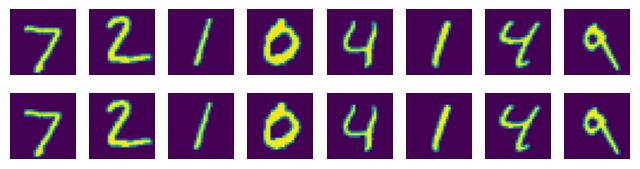

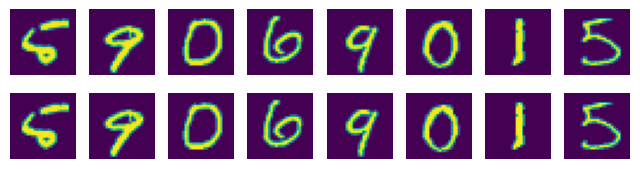

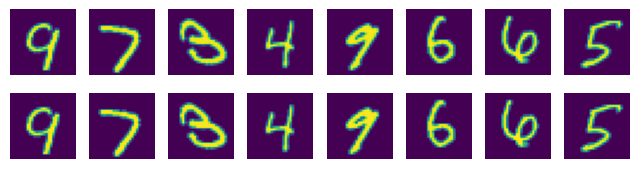

In [25]:
# 将生成图片和原始图片进行对比
for i, data in enumerate(test_dataloader):
    img, _ = data
    img = img.to(device)
    model = model.to(device)
    img_new = model(img).detach().cpu().numpy()
    img = img.cpu().numpy()
    plt.figure(figsize=(8, 2))
    for j in range(8):
        plt.subplot(2, 8, j + 1)
        plt.axis('off')
        plt.imshow(img_new[j].squeeze())
        plt.subplot(2, 8, 8 + j + 1)
        plt.axis('off')
        plt.imshow(img[j].squeeze())
    if i >= 2:
        break

In [26]:
def save_model_structure(model, device):
    x = torch.randn(1, 1, 28, 28).requires_grad_(True).to(device)
    y = model(x)
    vise = make_dot(y, params=dict(list(model.named_parameters()) + [('x', x)]))
    vise.format = "png"
    vise.directory = "./data"
    vise.view("2-Layer-CNN-AutoEncoder-Struction", cleanup=True)

In [27]:
# 保存模型架构图
save_model_structure(model, device)

## 习题27.4

&emsp;&emsp;证明当编码器和解码器都是线性函数时，主成分分析可以作为自动编码器学习的方法。

**解答：**

**解答思路：**  

1. 给出主成分分析的定义
2. 给出自动编码器学习过程
3. 证明当编码器和解码器都是线性函数时，主成分分析可以作为自动编码器学习的方法

**解答步骤：**   

**第1步：主成分分析的定义**

&emsp;&emsp;根据书中第16章的主成分分析的基本思想：

> &emsp;&emsp;主成分分析中，首先对给定数据进行规范化，使得数据每一变量的平均值为0，方差为1，之后对数据进行正交变换，原来由线性相关变量表示的数据通过正交变换变成由若干个线性无关的新变量表示的数据。新变量是可能的正交变换中变量的方差的和（信息保存）最大的，方差表示在新变量上信息的大小。将新变量依次称为第一主成分、第二主成分等。这就是主成分分析的基本思想。

&emsp;&emsp;根据书中第16.2.3节的算法16.1主成分分析算法：

> **算法16.1（主成分分析算法）**  
> 输入：$m \times n$样本矩阵$X$，其每一行元素的均值为零；  
> 输出：$k \times n$样本主成分矩阵$Y$。  
> 参数：主成分个数$k$  
> （1）构造新的$n \times m$矩阵
> $$
X' = \frac{1}{\sqrt{n - 1}} X^T
$$
> $X'$每一列的均值为零。  
> （2）对矩阵$X'$进行截断奇异值分解，得到
> $$
X' = U \Sigma V^T
$$
> 有$k$个奇异值、奇异向量。矩阵$V$的前$k$列构成$k$个样本主成分。  
> （3）求$k \times n$样本主成分矩阵
> $$
Y = V^T X
$$

**第2步：自动编码器学习过程**

&emsp;&emsp;根据书中第27章的本章概要的自动编码器的描述：

> &emsp;&emsp;自动编码器是用于数据表示的无监督学习的一种神经网络。自动编码器由编码器网络和解码器网络组成。学习时编码器将输入向量转换为中间表示向量，解码器再将中间表示向量转换为输出向量。编码器和解码器可以是
> $$
z = F(x) = a(W_E x + b_E) \\
y = G(z) = a(W_D z + b_D)
$$
> 学习的目标是尽量使输出向量和输入向量保持一致，或者说重建输入向量。认为学到的中间表示向量就是数据的表示。
> $$
L = \frac{1}{N} \sum_{i = 1}^N L(x_i, G(F(x_i)))
$$
> 学习的算法一般是梯度下降。自动编码器学习实际进行的是对数据的压缩。

**第3步：证明当编码器和解码器都是线性函数时，主成分分析可以作为自动编码器学习的方法**

&emsp;&emsp;假设给定样本矩阵$X = (x_1, x_2, \cdots, x_N)$，根据主成分分析算法，可以得到主成分为$K$个对应的单位特征向量$V$，样本主成分矩阵$Y$满足
$$
Y = V^T \cdot X
$$

这样，样本主成分矩阵$Y$可以作为样本矩阵$X$的低维表示，$V$维度是$N \times K$，其中$V = (v_1, v_2, \cdots, v_N)$

&emsp;&emsp;根据自动编码器中的编码阶段，编码器对数据进行压缩，当编码器是线性函数时，可用主成分矩阵$Y$表示编码器的输出，即
$$
z = F(x) = W_E x + b_E = V^T \cdot x
$$
其中$W_E = V^T, b_E = 0$ 

&emsp;&emsp;在解码阶段，解码器通过解压可以得到原始数据的近似，当解码器是线性函数时，可用单位特征向量$V$表示$W_D$，即
$$
y = G(z) = W_D \cdot z + b_D = V \cdot z 
$$
其中$W_D = V, b_D = 0$

&emsp;&emsp;综上所述，当损失函数是平方损失函数时，自动编码器学习的目标函数是
$$
\begin{aligned}
L 
&= \frac{1}{N} \sum_{i=1}^N \| x_i - G(F(x_i)) \| \\
&= \frac{1}{N} \sum_{i=1}^N \| x_i - v_i \cdot (v_i^T \cdot x_i) \| \\
&= \frac{1}{N} \sum_{i=1}^N \| x_i - v_i v_i^T x_i \|
\end{aligned}
$$

&emsp;&emsp;由于单位特征向量$V$可以使得样本矩阵$X$的所有线性变换中方差最大，故单位向量特征$V$能够使目标函数最小，因此，当编码器和解码器都是线性函数，且$b_E = b_D = 0$时，主成分分析可以作为自动编码器的学习方法。

## 习题27.5

&emsp;&emsp;解释为什么BERT预训练中的掩码语言模型化是基于去噪自动编码器原理的。

**解答：**

**解答思路：**  

1. 给出BERT预训练中的掩码语言模型化描述
2. 给出去噪自动编码器的原理
3. 解释BERT预训练中的掩码语言模型化是基于去噪自动编码器原理的原因

**解答步骤：**   

**第1步：BERT预训练中的掩码语言模型化的描述**

&emsp;&emsp;根据书中第27.2.2节的关于BERT预训练中的掩码语言模型化的描述：

> &emsp;&emsp;BERT模型的预训练由两部分组成，掩码语言模型化和下句预测。掩码语言模型化的目标是复原输入单词序列中被掩码的单词。可以看作是去噪自动编码器学习，对被掩码的单词独立地进行复原。掩码单词序列表示为$\tilde{x}$。  
> &emsp;&emsp;掩码语言模型化在每一个掩码位置计算条件概率：
> $$
P_{\theta} (x_i | \tilde{x}_0, \tilde{x}_1, \cdot, \tilde{x}_{m + n}) = \text{softmax} \left( W_x^T h_i^{(L)} \right) = \frac{\exp \left( w_{x_i}^T \cdot h_i^{(L)} \right)}{\displaystyle \sum_{x'_i} \exp \left( w_{x_i}^T \cdot h_i^{(L)} \right)}
$$
> 假设第$i$个位置是掩码位置，$h_i^{(L)}$是在第$L$层第$i$个位置的表示，$x_i$是预测的单词，$W_{x}$是单词的权重矩阵。

**第2步：去噪自动编码器的原理**

&emsp;&emsp;根据书中第27章的本章概要的去噪自动编码器的描述：

> &emsp;&emsp;去噪自动编码器是自动编码器的一种扩展，去噪自动编码器不仅可以用于数据表示学习，而且可以用户数据去噪。学习时首先根据对输入向量进行的随机变化，得到有噪声的输入向量。编码器将有噪声的输入向量转换为中间表示向量，解码器再将中间表示向量转换为输出向量。编码器、解码器、目标函数分别是
> $$
z = F(x) = a(W_E \tilde{x} + b_E) \\
y = G(z) = a(W_D z + b_D) \\
L = \frac{1}{N} \sum_{i = 1}^N L(x_i, G(F(\tilde(x)_i)))
$$
> 学习的目标是尽量使输出向量和原始输入向量保持一致，或者说重建原始输入向量。因为学习的目标是排除噪声的干扰重建数据，去噪自动编码器能更有效地学到数据的主要特征。

**第3步：解释BERT预训练中的掩码语言模型化是基于去噪自动编码器原理的原因**

&emsp;&emsp;BERT在预训练阶段，输入序列中的一些单词被随机遮掩，掩盖单词的过程相当于向输入序列中添加了一些噪声，得到有噪声的输入向量，模型需要预测并复原这些单词。这个过程类似于去噪自动编码器的学习过程，其中模型需要从缺失的或噪声的数据中重构原始数据。因此，掩码语言模型化提供了一些“噪音”，让模型学会从不完整的输入中推断出缺失的信息，从而提高模型的泛化能力。这也就说明了BERT预训练中的掩码语言模型化是基于去噪自动编码器原理的。

## 习题27.6

&emsp;&emsp;比较BERT与Transformer编码器在模型上的异同。

**解答：**

**解答思路：**  

1. 给出BERT的模型描述
2. 给出Transformer编码器的模型描述
3. 比较BERT与Transformer编码器在模型上的异同

**解答步骤：**   

**第1步：BERT模型的描述**

&emsp;&emsp;根据书中第27.2.2节的关于BERT的描述：

> &emsp;&emsp;BERT是双向Transformer编码器表示（Bidirectional Encoder Representations from Transformers）的缩写。BERT的模型基于Transformer的编码器，是双向语言模型。BERT的预训练主要是掩码语言模型化，使用大规模语料基于自去噪自动编码器原理进行模型的参数估计，学习的目标是复原给定的掩码单词序列中被掩码的每一个单词。学习和预测都是非自回归过程（Non-autoregressive process）。
> &emsp;&emsp;每一个单词序列是一个句子或一段文章。首先经过输入层，产生初始的单词表示向量的序列，记作矩阵$H^{(0)}$：
> $$
H^{(0)} = X + S + E \tag{27.22}
$$
> 其中，矩阵$X$表示单词的词嵌入的序列$X = (x_0, x_1, \cdots, x_{m + n})$；矩阵$E$表示单词的位置嵌入的序列$E=(e_0, e_1, \cdots, e_{m + n})$；矩阵$S$是区别前后单词的标记序列$S=(a, a, \cdots, a, b, b, \cdots, b)$，含有$m + 1$个向量$a$和$n$个向量$b$。$X,E,S,H^{(0)}$是$d \times (m + n + 1)$矩阵，设词嵌入、位置嵌入、标记向量的维度是$d$。

&emsp;&emsp;根据书中第27章的本章概要的BERT模型的描述：

> &emsp;&emsp;BERT模型的输入是两个合并的单词序列。首先经过输入层，产生初始的单词表示向量的序列。之后经过$L$个Transformer编码层，得到单词的表示向量的序列。BERT模型的输出是在单词序列的各个位置上的条件概率。  
> &emsp;&emsp;BERT模型的预训练由掩码语言模型化和下句预测组成。掩码语言模型化的目标是复原输入单词序列中被掩码的单词。下句预测的目标是判断输入单词序列是否来自同一篇文章。预训练以掩码语言模型化为主，其损失函数是
> $$
L_1 = - \sum_{i = 0}^{m + n} \delta_i \log P_{\theta} (x_i | \tilde{x}_0, \tilde{x}_1, \cdots, \tilde{x}_{m + n})
$$
> &emsp;&emsp;BERT微调时，通过优化下游任务的目标函数，进一步调节模型的参数。

**第2步：Transformer编码器的模型描述**

&emsp;&emsp;根据书中第26.3.1节关于Transformer编码器的描述：  

> &emsp;&emsp;Transformer（转换器）由编码器和解码器组成。编码器有1个输入层、6个编码层（一般是$L$层）。解码器有1个输入层、6个解码层、1个输出层。编码器的输入层与第1个编码层连接，第1个编码层再与第2个编码层连接，依次连接，直到第6个编码层。解码器的输入层与第1个解码层连接，第1个解码层再与第2个解码层连接，依次连接，直到第6个解码层。第6个解码层再与输出层连接。第6个编码层与各个解码层之间也有连接。  
> &emsp;&emsp;编码器的6个编码层将输入单词序列进行转换，得到中间表示序列。  
> &emsp;&emsp;编码器的6个编码层有相同的结构，每一个编码层由自注意力子层和前馈网络子层两部分组成。  
> &emsp;&emsp;在编码器的输入层，输入序列的各个位置有单词的词嵌入（word embedding）和位置嵌入（position embedding），其中位置嵌入表示在序列中的位置。在每一个位置以词嵌入和位置嵌入的和作为该位置的输入向量。单词的词嵌入通常通过对单词的独热向量进行一个线性变化得到，即用一个矩阵乘以独热向量，矩阵称为词嵌入矩阵。

&emsp;&emsp;根据书中第26.3.1节关于Transformer编码器计算公式：
> &emsp;&emsp;在编码器的输入层通过线性变换获得单词的词嵌入。
> $$
e = W_e \cdot w \tag{26.26}
$$
> 其中，$w$是单词的独热向量，$e$是单词的词嵌入，$W_e$是嵌入矩阵。嵌入矩阵在学习中自动获得。  
> &emsp;&emsp;编码器的输入层的每一个位置的输入向量是
$$
e + p \tag{26.27}
$$
其中，$e$是该位置的词嵌入，$p$是该位置的位置嵌入。  
> &emsp;&emsp;编码器的每一层的每一个位置的前馈网络是
> $$
\text{ffn} (z) = W_2 \text{relu} (W_1 z + b_1) + b_2 \tag{26.28}
$$
其中，$W_1$和$W_2$是权重矩阵，$b_1$和$b_2$是偏置向量。  
> &emsp;&emsp;编码器的每一层的每一个位置的层归一化函数是
> $$
\text{norm} (z) = \gamma \frac{z - u \cdot \boldsymbol{1}}{\sqrt{\sigma^2 + \varepsilon}} + \beta \cdot \boldsymbol{1}
$$
> 其中，$u$是均值，$\sigma^2$是方差，$\gamma$和$\beta$是参数，$\varepsilon$是常量。  
> &emsp;&emsp;编码器的输入层的计算可以写作
> $$
H_E^{(0)} = E_E + P_E \tag{26.31}
$$
> &emsp;&emsp;编码器的第$l$个编码器的多头自注意力子层和前馈网络子层计算可以写作
> $$
Z_E^{(l)} = \text{norm} (H_E^{(l - 1)} + \text{multi\_attend} (H_E^{(l - 1)}, H_E^{(l - 1)}, H_E^{(l - 1)})) \tag{26.32}
$$
> $$
H_E^{(l)} = \text{norm} (Z_E^{(l)} + \text{ffn} (Z_E^{(l)})) \tag{26.33}
$$
> 其中，$H_E^{(l)}$是第$l$个编码层的所有位置的输出，$H_E^{(l - 1)}$是所有位置的输入，$Z_E^{(l)}$是中间结果；$\text{ffn}()$和$\text{norm}()$的计算针对矩阵的每一列，$\text{multi\_attend()}$的计算针对矩阵整体进行。

**第3步：比较BERT与Transformer编码器在模型上的异同**

- 相同点：
    1. 两者都是基于多头注意力机制的架构设计，使用了自注意力机制来处理输入序列。
    2. 两者都使用了残差连接和层归一化。
    3. 两者都可以使用预训练技术提高模型的泛化能力。

- 不同点：
    1. BERT模型在Transformer模型的基础上添加了掩码语言模型和下句预测任务。
    2. BERT模型在训练的时候会在其后添加线性层和softmax层，用于预测掩码语言模型和下句预测任务；Transformer编码器则是直接和Transformer解码器连接，用于预测序列的下一个单词。
    3. BERT模型中输入序列的嵌入由词嵌入、位置嵌入、区别前后单词的标记序列的和组成；Transformer编码器模型的输入序列的嵌入由词嵌入、位置嵌入的和组成。
    4. BERT模型使用了双向语言模型，能够同时处理输入序列的左右两个方向；Transformer编码器通常只处理从左到右的输入序列。
    5. BERT模型的位置嵌入通过学习得到；Transformer的位置嵌入由公式计算得到。

## 参考文献

【1】Matthew E. Peters and Mark Neumann and Mohit Iyyer and Matt Gardner and Christopher Clark and Kenton Lee and Luke Zettlemoyer. 2018. Deep contextualized word representations. arXiv, abs/1802.05365  
【2】ELMo：https://allenai.org/allennlp/software/elmo  